In [1]:
!pip install imagecodecs -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

import tifffile as tfl
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from loss import bce_dice_loss, dice_coef
from metrics import recall_m,precision_m,f1_m
from tensorflow import keras
import gdal
from image_utils import pad,crop,reconstruct

In [4]:
#Load Model

model=keras.models.load_model('/content/drive/MyDrive/Inference_data/3_Train_S1 Hand_Label_S1_otsu.h5',
                                 custom_objects={ 'bce_dice_loss': bce_dice_loss, 
                                                  'dice_coef':dice_coef,
                                                 'f1_m':f1_m,
                                                 'precision_m':precision_m,
                                                 'recall_m':recall_m} )

In [5]:
sentinel1_img = '/content/drive/MyDrive/Inference_data/Inference1_sentinel1_data.tif'

In [6]:
original_image = tfl.imread(sentinel1_img)
img_height, img_width = original_image.shape[:-1]



In [7]:
img_width

6666

# Image padding

In [8]:

padded_img = pad("/content/padded_image_v2/",tfl.imread(sentinel1_img),512,512)

image width =  6666 , image height =  7101
pad width =  502 , pad height =  67
Padded Image shape (7168, 7168, 3)


# Image Cropping

In [9]:

ds = gdal.Open(sentinel1_img)
ds_arr = ds.ReadAsArray()
print(ds_arr.shape)

arr,box_list = crop(ds,512,512,'/content/test_cropped_version/')


(3, 7101, 6666)
(3, 7101, 6666)
coordinates [0, 0]
coordinates [512, 0]
coordinates [1024, 0]
coordinates [1536, 0]
coordinates [2048, 0]
coordinates [2560, 0]
coordinates [3072, 0]
coordinates [3584, 0]
coordinates [4096, 0]
coordinates [4608, 0]
coordinates [5120, 0]
coordinates [5632, 0]
coordinates [6144, 0]
coordinates [0, 512]
coordinates [512, 512]
coordinates [1024, 512]
coordinates [1536, 512]
coordinates [2048, 512]
coordinates [2560, 512]
coordinates [3072, 512]
coordinates [3584, 512]
coordinates [4096, 512]
coordinates [4608, 512]
coordinates [5120, 512]
coordinates [5632, 512]
coordinates [6144, 512]
coordinates [0, 1024]
coordinates [512, 1024]
coordinates [1024, 1024]
coordinates [1536, 1024]
coordinates [2048, 1024]
coordinates [2560, 1024]
coordinates [3072, 1024]
coordinates [3584, 1024]
coordinates [4096, 1024]
coordinates [4608, 1024]
coordinates [5120, 1024]
coordinates [5632, 1024]
coordinates [6144, 1024]
coordinates [0, 1536]
coordinates [512, 1536]
coordinates

# Creating data for inferencing 

In [10]:
import glob
cropped_tiles = []
# cr_images =glob.glob('/content/cropped_images/*.tif')

for i in arr:
  cr_images_gdal= np.moveaxis(gdal.Open(i).ReadAsArray(),0,-1)
  cropped_tiles.append(cr_images_gdal)

cropped_tiles_arr = np.array(cropped_tiles)

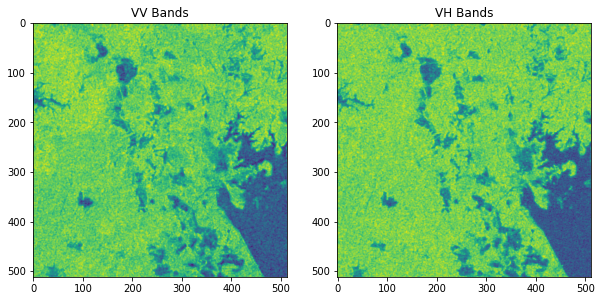

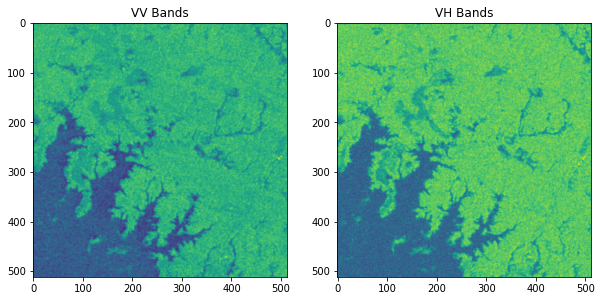

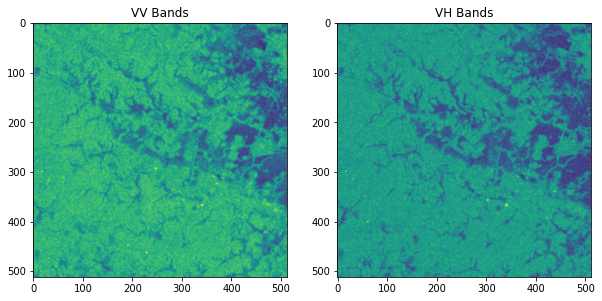

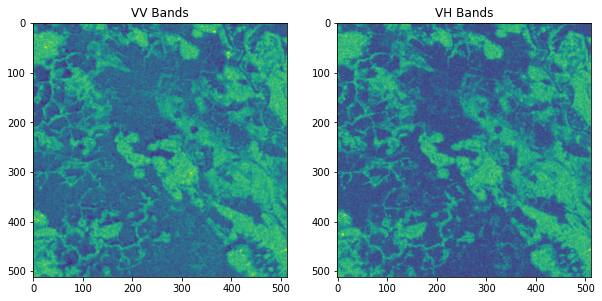

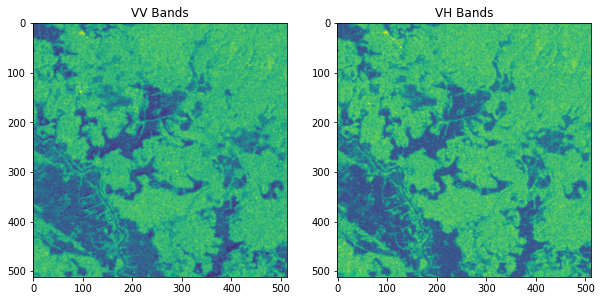

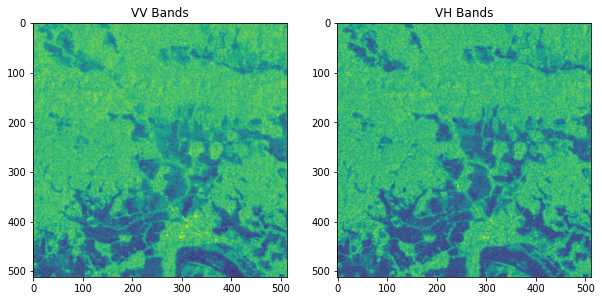

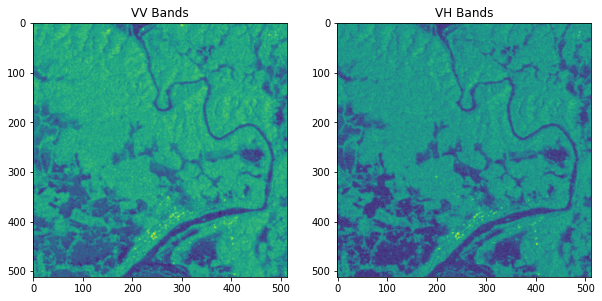

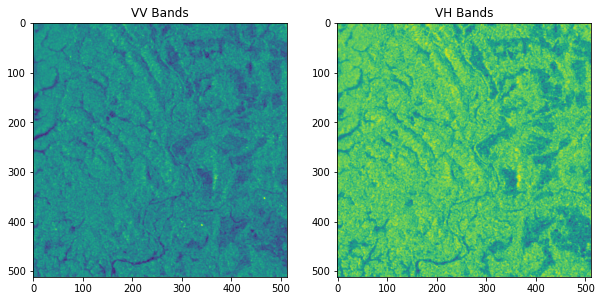

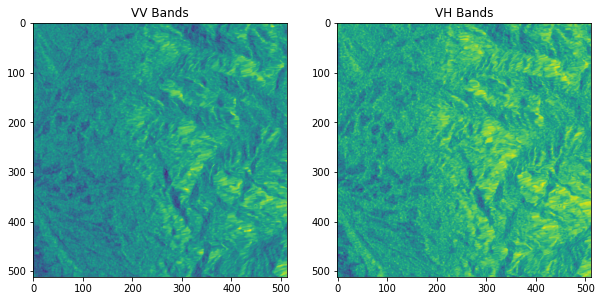

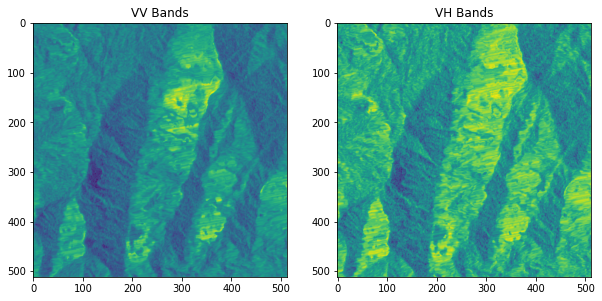

In [11]:
cropped_tiles_arr =cropped_tiles_arr[:,:,:,:2] # taking out the last bands, do not need to perform for other images
for i in range(10):
  fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
  ax1.imshow(cropped_tiles_arr[i][:,:,0])
  ax1.set_title('VV Bands')
  ax2.imshow(cropped_tiles_arr[i][:,:,1])
  ax2.set_title('VH Bands')

# Model Prediction

In [12]:
model_predictions = model.predict(cropped_tiles_arr,verbose=1)

preds = np.squeeze(model_predictions)

threshold = 0.5
preds = preds > threshold
#preds =np.argmax(preds[0],axis=-1)
print(preds.shape)
print(np.unique(preds))

6/6 [==============================] - 17s 605ms/step
(169, 512, 512)
[False  True]


# Image Reconstruction

14 14
(0, 0, 7101, 6666)


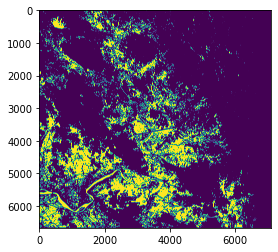

In [13]:
new_img = reconstruct(preds,img_height,img_width,512,512,box_list,True)
plt.imshow(new_img)

# Predictions

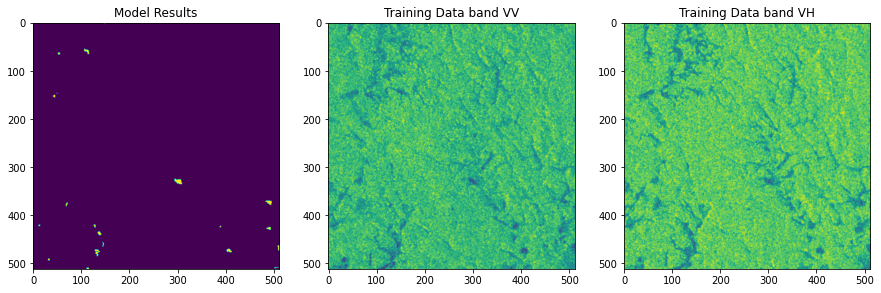

In [ ]:
for i in range(10):
  n= np.random.randint(preds.shape[0])
  fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,15))
  ax1.imshow(preds[n])
  ax1.set_title('Model Results')
  ax2.imshow(cropped_tiles_arr[n][:,:,0])
  ax2.set_title('Training Data band VV')
  ax3.imshow(cropped_tiles_arr[n][:,:,1])
  ax3.set_title('Training Data band VH')
  # fig.savefig('/content/Preds/inference_result_'+str(i)+'_.png')

In [ ]:
!zip -r '/content/inferencing_results.zip' '/content/Preds'